# Heterogeneous Federated Transfer Learning

## Overview

This tutorial builds upon the previous notebook on **Transfer Learning (TL)** and takes a step further into the field of **Federated Transfer Learning (FTL)**—specifically in **heterogeneous settings** where client models and data distributions differ.

In this tutorial, you will:

- **Implement Heterogeneous FTL**, where clients use **different model architectures** (e.g., ResNet18 vs. a simple CNN).
- **Explore the impact of varying data distributions** (IID vs. non-IID) across clients.
- **Run experiments** to compare heterogeneous vs. homogeneous setups under different data conditions.
- **Evaluate results**, focusing on convergence, performance per client, and the benefits of TL in federated contexts.
- **Leverage the Flower framework** for federated orchestration and PyTorch for model training.

By the end of this tutorial, you'll have hands-on experience implementing and analyzing a **heterogeneous FTL setup**, gaining insight into how TL, FL, and data distribution intricacies interact in real-world decentralized environments.

Note: we recommend to run this notebook in colab, there we tested out and didn't have dependency conflicts. For local environments, flower tends to be harder to install without running into conflicts.


## Introduction

In many real-world applications, data isn't distributed nicely or evenly. Think of a scenario in healthcare, where different hospitals collect data from different patient populations. One hospital might see mostly older patients with diabetes, while another might serve mostly young patients with asthma. This is a typical case of non-IID data – each client (or hospital) has access to a completely different kind of data. This is exactly where standard Federated Learning methods like FedAvg start to struggle.

In our setup, we try to simulate this exact heterogeneity. While my teammate shows how basic Transfer Learning works under idealized, IID conditions, I focus on a setup that’s closer to reality. We know that in practice, data is often non-IID, and worse: the clients might not even use the same model architecture, feature space, or input distributions. This is where Heterogeneous Federated Transfer Learning (FTL) becomes interesting.

The goal is to still allow collaboration between clients — even if their data or models are fundamentally different — by transferring only what’s useful. This notebook explores how well this works when the data is not evenly spread across clients and when they operate under their own, unique data distributions. Especially with Dirichlet partitions, we see patterns that are far more realistic than the artificially extreme partitions often used in FL literature.


In this notebook we will mainly look at how to split the data in various non-IID ways using multiple FL-Strategies. Then we will evaluate how it impacts the performance of our resulting model.

In order to be comparable to the first notebook, we will use exactely the same setup. Since non-IID data creates some edge cases, we will have to adapt a few classes and just copy the others. Feel free to skip this chapter for now, since it's not important for your understanding, rather focus on the next one where we actually partition the non-IID data.

# Setup

## Setup similar to first notebook (small adaptations)

In [ ]:
# install all the required dependencies
%pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib
#%pip install -U datasets fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48

In [ ]:
%pip uninstall -y cryptography
%pip install cryptography==41.0.7 --force-reinstall


Found existing installation: cryptography 44.0.3
Uninstalling cryptography-44.0.3:
  Successfully uninstalled cryptography-44.0.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 467.2/467.2 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.6/117.6 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: pycparser
    Found existing installation: pycparser 2.22
    Uninstalling pycparser-2.22:
      Successfully uninstalled pycparser-2.22
  Attempting uninstall: cffi
    Found existing installation: cffi 1.17.1
    Uninstalling cffi-1.17.1:
      Successfully uninstalled cffi-1.17.1
  Attempting uninstall: cryptography
    Found existing installation: cryptography 3.4.8
    Uninstalling cryptography-3.4.8:
      Successfully uninstalled cryptography-3.4.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the follo

In [ ]:
#do all the needed imports
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import DirichletPartitioner
from flwr.server.strategy import FedProx
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from flwr_datasets import FederatedDataset

from IPython.display import Image, display


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()


Training on cuda
Flower 1.18.0 / PyTorch 2.6.0+cu124


In [ ]:
#import the pretrained model (used for TL)
class Net(nn.Module):
    def __init__(self, num_classes=10) -> None:
        super(Net, self).__init__()
        # Load a pre-trained ResNet18 model
        self.model = models.resnet18()

        # Replace the final fully connected layer to match your output size
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

def get_resnet18(num_classes=10, pretrained=False):
    """Create a ResNet18 model with specified number of output classes."""
    model = models.resnet18()

    # Modify the final fully connected layer to match our number of classes
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model

def set_parameters(net: nn.Module, parameters: List[np.ndarray]) -> None:
    state_dict = net.state_dict()
    new_state_dict = OrderedDict()
    for (key, old_tensor), param in zip(state_dict.items(), parameters):
        new_state_dict[key] = torch.tensor(param, dtype=old_tensor.dtype)
    net.load_state_dict(new_state_dict, strict=True)


def get_parameters(net: nn.Module) -> List[np.ndarray]:
    return [val.cpu().numpy() for val in net.state_dict().values()]


In [ ]:
#define train/test functions
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
          ### write into file
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [ ]:
#now we define a Heterogeneous FlowerClient (evaluate method is adapted)
class FlowerClientHeterogeneous(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        try:
          set_parameters(self.net, parameters)
          train(self.net, self.trainloader, epochs=1)
          return get_parameters(self.net), len(self.trainloader), {}
        except Exception as e:
            print(f"Client {self.client_id} failed during fit: {e}")
            raise
    def evaluate(self, parameters, config):
        if self.valloader is None:
          return 0.0, {}  # Or any default loss/metric

        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

Also we will define the evaluation function used for metrics(similar to first notebook):

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}


In [ ]:
# Specify the resources each of your clients need
# By default, each client will be allocated 1x CPU and 0x GPUs
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

# When running on GPU, assign an entire GPU for each client
if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.1}}
    # Refer to our Flower framework documentation for more details about Flower simulations
    # and how to set up the `backend_config`

## Paritioning of non-IID data Setup

First of all we define some parameters:

In [ ]:
NUM_CLIENTS = 5
BATCH_SIZE = 16

In this section we are defining all the necessary functions for partitioning the data in a non-IID way. Also we define functions used to print out and visualize the created distributions, in order to make it more understandable.

In order to test out different partitioners, we adapt load_datasets so that we can pass a partitioner as an argument:

In [ ]:
def load_datasets(partition_id: int, fds: FederatedDataset, partitioner):
    """Load client-specific CIFAR-10 data with customizable non-IID partitioning and train/val split.

    Args:
        partition_id (int): ID of the client partition.
        dataset: A Flower federated dataset, thats already partitioned

    Returns:
        Tuple of (trainloader, valloader, testloader).
    """
    try:
      partition = fds.load_partition(partition_id=partition_id)
    except Exception as e:
      print(f"[Client {partition_id}] Failed to load partition: {e}")
      raise RuntimeError(f"Client {partition_id} failed to load partition: {e}")

    # Define standard preprocessing transforms
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    def apply_transforms(batch):
        batch["img"] = [transform(img) for img in batch["img"]]
        return batch

    # Apply transforms to partitioned data
    partition = partition.with_transform(apply_transforms)

    # Split into 80% train, 20% val
    total_size = len(partition)
    val_size = int(0.2 * total_size)
    train_size = total_size - val_size
    train_dataset, val_dataset = random_split(partition, [train_size, val_size])

    # DataLoaders
    trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    valloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Load and transform centralized test set
    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

    return trainloader, valloader, testloader



In [ ]:
def model_fn():
    return Net(num_classes=10).to(DEVICE)


Since load_datasets is called in the client_fn, we have to adapt this one as well. However, client_fn is predefined with a signature and we cannot just add a new argument to it, therefore we use the factory-pattern to define the function accordingly to a given partitioner:

In [ ]:
#client_fn factory
def create_client_fn(fds, partitioner):
    def client_fn(context: Context) -> Client:
        net = get_resnet18(num_classes=10).to(DEVICE)
        partition_id = context.node_config["partition-id"]
        trainloader, valloader, testloader = load_datasets(partition_id, fds=fds, partitioner=partitioner)
        return FlowerClientHeterogeneous(
            net=net,
            trainloader=trainloader,
            valloader=valloader,
        ).to_client()
    return client_fn



Also for the server_fn we create a Factory, so that we can use it with different kinds of FL-Strategies:

In [ ]:
from flwr.common import parameters_to_ndarrays

def get_evaluate_fn(model, metrics_log, dataloader):
    def evaluate(server_round, parameters, config):
        # `parameters` is already a list of NumPy arrays (after conversion by FedAvg)
        weights = parameters  # Keine weitere Umwandlung nötig

        # Gewichte ins Modell laden
        state_dict = dict(zip(model.state_dict().keys(), [torch.tensor(w) for w in weights]))
        model.load_state_dict(state_dict, strict=True)

        correct, total = 0, 0
        with torch.no_grad():
            for batch in dataloader:
                x = batch["img"]
                y = batch["label"]

                # Falls x oder y Listen sind, in Tensoren umwandeln
                if isinstance(x, list):
                    x = torch.stack(x)
                if isinstance(y, list):
                    y = torch.tensor(y)

                x, y = x.to(DEVICE), y.to(DEVICE)
                preds = model(x).argmax(dim=1)
                correct += (preds == y).sum().item()
                total += y.size(0)

        accuracy = correct / total
        print(f"📊 Server round {server_round} accuracy: {accuracy:.4f}")
        metrics_log.append(accuracy)
        return 0.0, {"accuracy": accuracy}

    return evaluate



Make it so that multiple types of the offered Flower Strategies can be used:

In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms

def strategy_fn(model, metrics_log, fds, strategy_cls, **strategy_kwargs):
    # Define transforms (same as in your training/val loader)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    def apply_transforms(batch):
        batch["img"] = [transform(img) for img in batch["img"]]
        return batch

    # Load centralized test split and apply transforms
    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=32, shuffle=False)

    # Get evaluation function using testloader
    evaluate_fn = get_evaluate_fn(model, metrics_log, testloader)

    # Instantiate and return the strategy with the evaluate_fn and other kwargs
    return strategy_cls(evaluate_fn=evaluate_fn, **strategy_kwargs)


In [ ]:
def server_fn_factory(strategy_fn, model_fn, metrics_log, fds, strategy_cls, num_rounds, **strategy_kwargs):
    def server_fn(context: Context) -> ServerAppComponents:
        model = model_fn()
        strategy = strategy_fn(model, metrics_log, fds, strategy_cls, **strategy_kwargs)
        config = ServerConfig(num_rounds=num_rounds, round_timeout=120)
        return ServerAppComponents(strategy=strategy, config=config)
    return server_fn


In [ ]:
import os
import matplotlib.pyplot as plt

def plot_accuracy(metrics_log, name, save_dir):
    plt.plot(metrics_log, marker='o')
    plt.title(f"Accuracy over Rounds: {name}")
    plt.xlabel("Round")
    plt.ylabel("Accuracy")
    plt.grid(True)

    # Save the plot
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(os.path.join(save_dir, f"{name}_accuracy.png"))

    # Show the plot in interactive environments (like Colab or Jupyter)
    plt.show()

    # Close to free memory if used repeatedly
    plt.close()



Also we define a function to create a FederatedDataset for a specific partitioner using Cifar-10:

In [ ]:
def create_federated_dataset(partitioner) -> FederatedDataset:
    """Create a FederatedDataset with the specified partitioner."""
    return FederatedDataset(
        dataset="uoft-cs/cifar10",
        partitioners={"train": partitioner}
    )

Now we define a function that let's us see how the Federated-Dataset is distributed (and optionally gives us a plot of it):

In [ ]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def print_partition_statistics(fds, num_partitions: int, plot: bool = True):
    """Prints and plots class distribution per client."""
    print("Class distribution per client partition:\n")

    class_counts = []
    all_labels = list(range(10))  # CIFAR-10 has 10 classes

    for pid in range(num_partitions):
        partition = fds.load_partition(partition_id=pid)

        # Handle both DatasetDict and Dataset
        dataset = partition["train"] if isinstance(partition, dict) and "train" in partition else partition
        labels = dataset["label"]
        counter = Counter(labels)
        row = [counter.get(label, 0) for label in all_labels]
        class_counts.append(row)

    df = pd.DataFrame(class_counts, columns=[f"Class {i}" for i in all_labels])
    df.index = [f"Client {i}" for i in range(num_partitions)]

    # Print horizontally compact table
    print(df.to_string())

    if plot:
        # Prepare data
        ind = np.arange(num_partitions)  # Client positions
        width = 0.08  # Width of each bar

        fig, ax = plt.subplots(figsize=(14, 6))

        # Stack bars side-by-side per client
        for i, class_label in enumerate(df.columns):
            ax.bar(ind + i * width, df[class_label], width, label=class_label)

        # Add client boundaries
        for i in range(num_partitions):
            plt.axvline(i + 0.5, color="gray", linestyle="--", alpha=0.3)

        ax.set_xticks(ind + width * 5)
        ax.set_xticklabels([f"Client {i}" for i in range(num_partitions)])
        ax.set_xlabel("Client")
        ax.set_ylabel("Number of Samples")
        ax.set_title("Class Distribution per Client")
        ax.legend(title="Class", bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.tight_layout()
        plt.grid(axis="y", linestyle="--", alpha=0.5)
        plt.show()


# Different Partitioners
Now that we have the basic setup done, we will provide a few examples on popular Partitioners, however there is a full list of them (https://flower.ai/docs/datasets/tutorial-use-partitioners.html). You can easily test them out by just redifing the partitioner in the examples below.

## IID-Partitioner for comparison

This partitioner should just divide our dataset equally among clients. It still uses random sampling, therefore it doesn't give us a completely equal split, however we can consider it as IID.

In [ ]:
from flwr_datasets.partitioner import IidPartitioner

iid_partitioner = IidPartitioner(num_partitions=NUM_CLIENTS)
iid_fds = create_federated_dataset(iid_partitioner)

Let's take a look at the distribution:

Class distribution per client partition:



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


          Class 0  Class 1  Class 2  Class 3  Class 4  Class 5  Class 6  Class 7  Class 8  Class 9
Client 0     1011      969     1007      958     1014     1021     1010     1006      989     1015
Client 1     1020      981      993      996      984     1001     1043      993      990      999
Client 2      952     1033     1000     1052      998      973      976      999      988     1029
Client 3      989     1014      992     1032     1035      999      962     1000      991      986
Client 4     1028     1003     1008      962      969     1006     1009     1002     1042      971


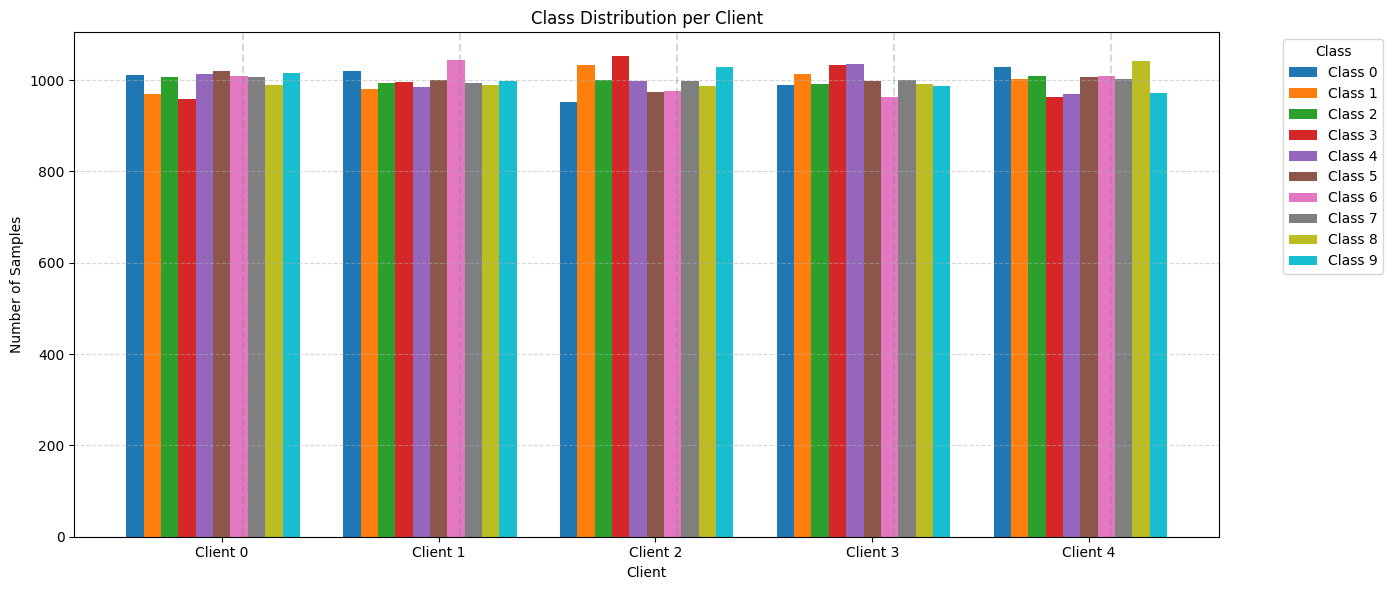

In [ ]:
print_partition_statistics(iid_fds, num_partitions=NUM_CLIENTS, plot=True)

## PathologicalPartitioner

This partitioner will create a "radical" non-IID Dataset, where each partition only gets a specific amount of classes. This amount is specified by the parameter num_classes_per_partition.

So let's create a FederatedDataset with num_classes_per_partition=2 (extremely non-IID)

In [ ]:
from flwr_datasets.partitioner import PathologicalPartitioner

partitioner_pathological_2 = PathologicalPartitioner(num_partitions=NUM_CLIENTS, num_classes_per_partition=2, partition_by="label")
fds_pathological_2 = create_federated_dataset(partitioner_pathological_2)

Class distribution per client partition:



/usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [1, 2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
  warnings.warn(


          Class 0  Class 1  Class 2  Class 3  Class 4  Class 5  Class 6  Class 7  Class 8  Class 9
Client 0     1667        0        0        0        0        0        0     2500        0        0
Client 1        0        0        0     5000     5000        0        0        0        0        0
Client 2     1667        0        0        0        0        0     2500        0        0        0
Client 3     1666        0        0        0        0     5000        0        0        0        0
Client 4        0        0        0        0        0        0     2500     2500        0        0


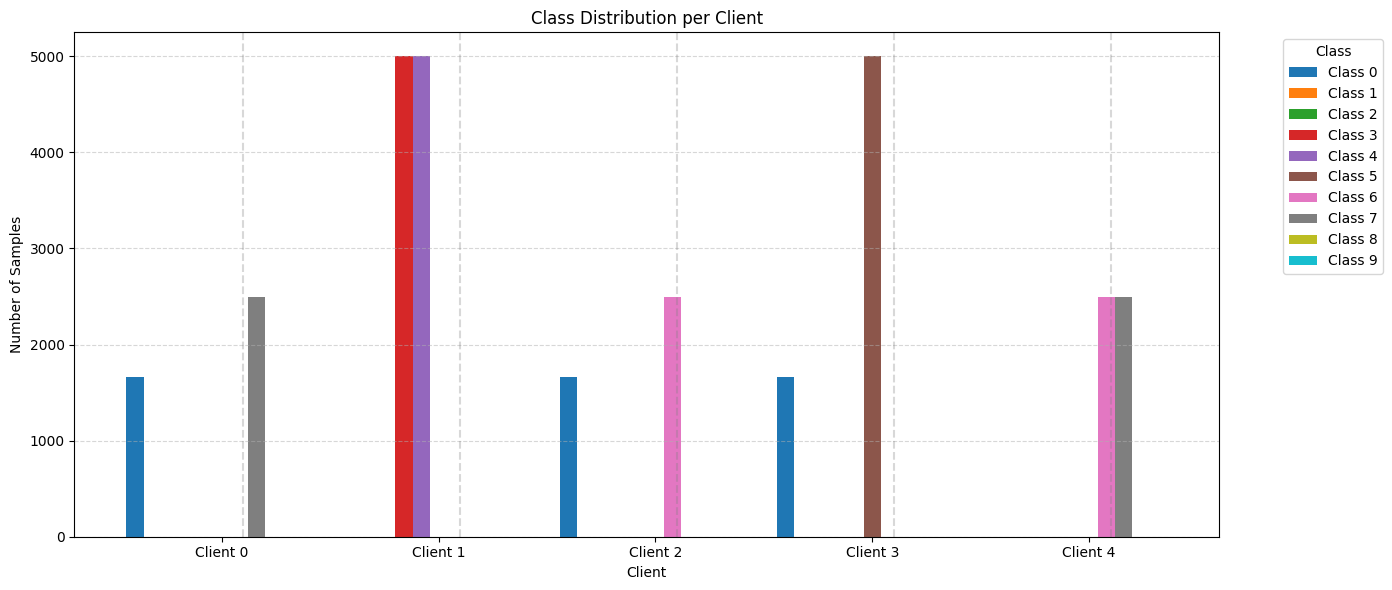

In [ ]:
print_partition_statistics(fds_pathological_2, num_partitions=NUM_CLIENTS, plot=True)

And let's also create a FederatedDataset with num_classes_per_partition=5 (still non-IID but more realistic)

In [ ]:
from flwr_datasets.partitioner import PathologicalPartitioner

partitioner_pathological_5 = PathologicalPartitioner(num_partitions=NUM_CLIENTS, num_classes_per_partition=5, partition_by="label")
fds_pathological_5 = create_federated_dataset(partitioner_pathological_5)

Class distribution per client partition:

          Class 0  Class 1  Class 2  Class 3  Class 4  Class 5  Class 6  Class 7  Class 8  Class 9
Client 0     2500        0        0     1250     1667     1667        0     1667        0        0
Client 1     2500        0        0     1250        0        0     2500     1667        0     5000
Client 2        0     2500        0     1250     1667     1667        0        0     1667        0
Client 3        0        0     2500     1250     1666        0        0     1666     1667        0
Client 4        0     2500     2500        0        0     1666     2500        0     1666        0


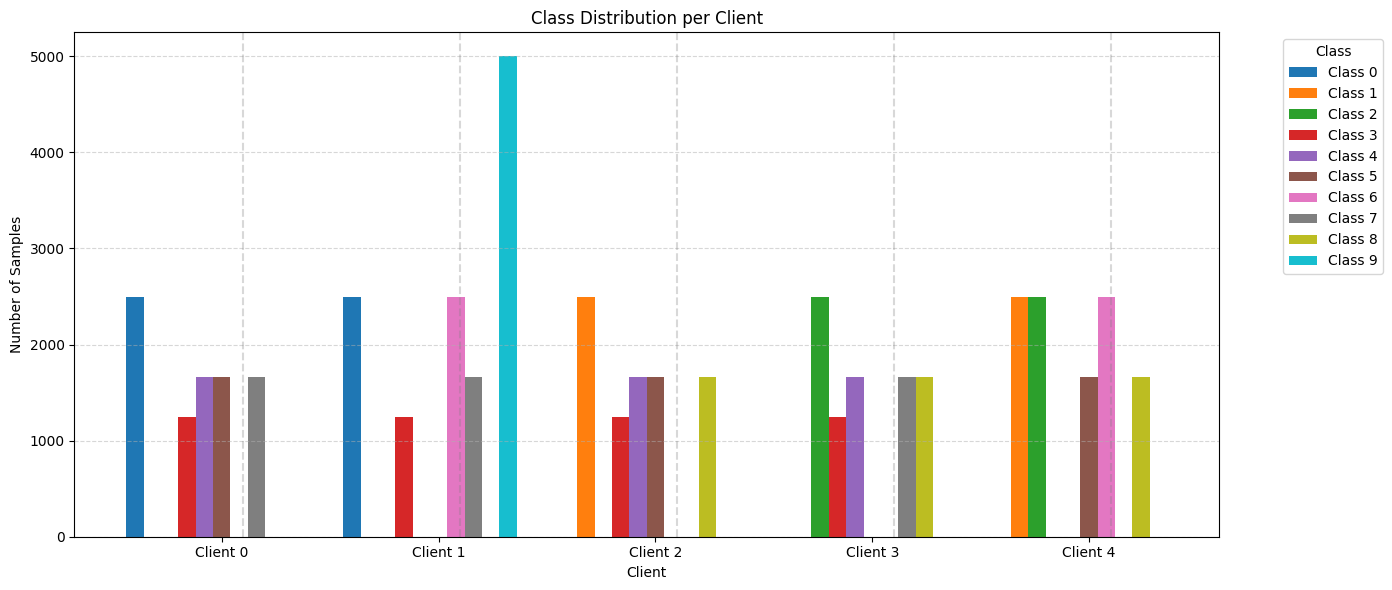

In [ ]:
print_partition_statistics(fds_pathological_5, num_partitions=NUM_CLIENTS, plot=True)

## DirichletPartitioner

As a first non-IID Partitioner, we will use the DirichletPartitioner (https://flower.ai/docs/datasets/ref-api/flwr_datasets.partitioner.DirichletPartitioner.html#flwr_datasets.partitioner.DirichletPartitioner)

The most important parameter for this distribution is the alpha-parameter:

For low alpha (e.g. 0.1) it makes each client biased towards a few classes, highly non-IId.

For high alpha (e.g. 10) it makes a more balanced class distribution (closer to IID)

Let's first create a really non-IID partitioning (alpha=0.1)

In [ ]:
partitioner_low_alpha = DirichletPartitioner(num_partitions=NUM_CLIENTS, alpha=0.1, partition_by="label")
fds_low_alpha = create_federated_dataset(partitioner_low_alpha)

Class distribution per client partition:

          Class 0  Class 1  Class 2  Class 3  Class 4  Class 5  Class 6  Class 7  Class 8  Class 9
Client 0     1070        6      224        0        0     2562        1     4949      456        0
Client 1     3023      675     4482     4930     3735      479      369        1     3488     4374
Client 2        0     3795      292        0     1248     1528        8       49        0       87
Client 3      906        2        1        0       16      430       83        0     1055      538
Client 4        1      522        1       70        1        1     4539        1        1        1


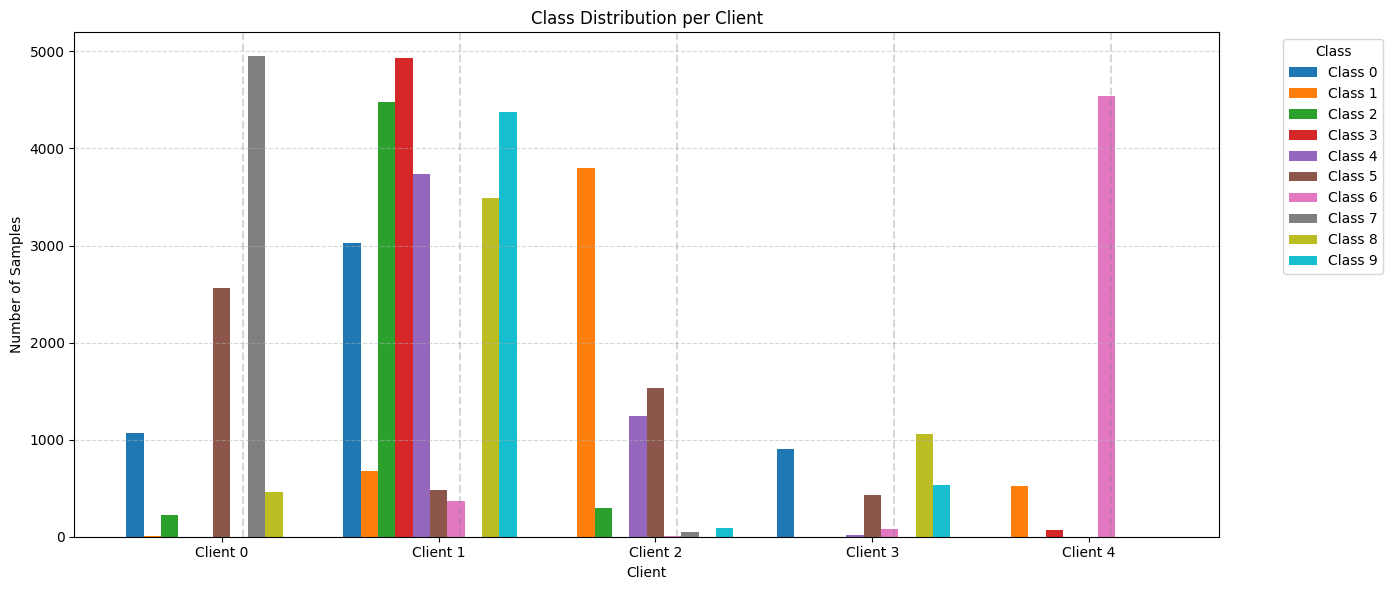

In [ ]:
print_partition_statistics(fds_low_alpha, num_partitions=NUM_CLIENTS, plot=True)

For comparison, we will also create one FederatedDataset with high_alpha

In [ ]:
partitioner_high_alpha = DirichletPartitioner(num_partitions=NUM_CLIENTS, alpha=10, partition_by="label")
fds_high_alpha = create_federated_dataset(partitioner_high_alpha)

Class distribution per client partition:

          Class 0  Class 1  Class 2  Class 3  Class 4  Class 5  Class 6  Class 7  Class 8  Class 9
Client 0     1125     1240      844     1417     1313      831     1106     1649     1271     1308
Client 1     1289      659     1297      700     1165      613      862      749     1209     1383
Client 2      505      789      779      798      639     1173      977     1074      929      979
Client 3     1064     1023     1059     1139      910     1389      949      855      694      618
Client 4     1017     1289     1021      946      973      994     1106      673      897      712


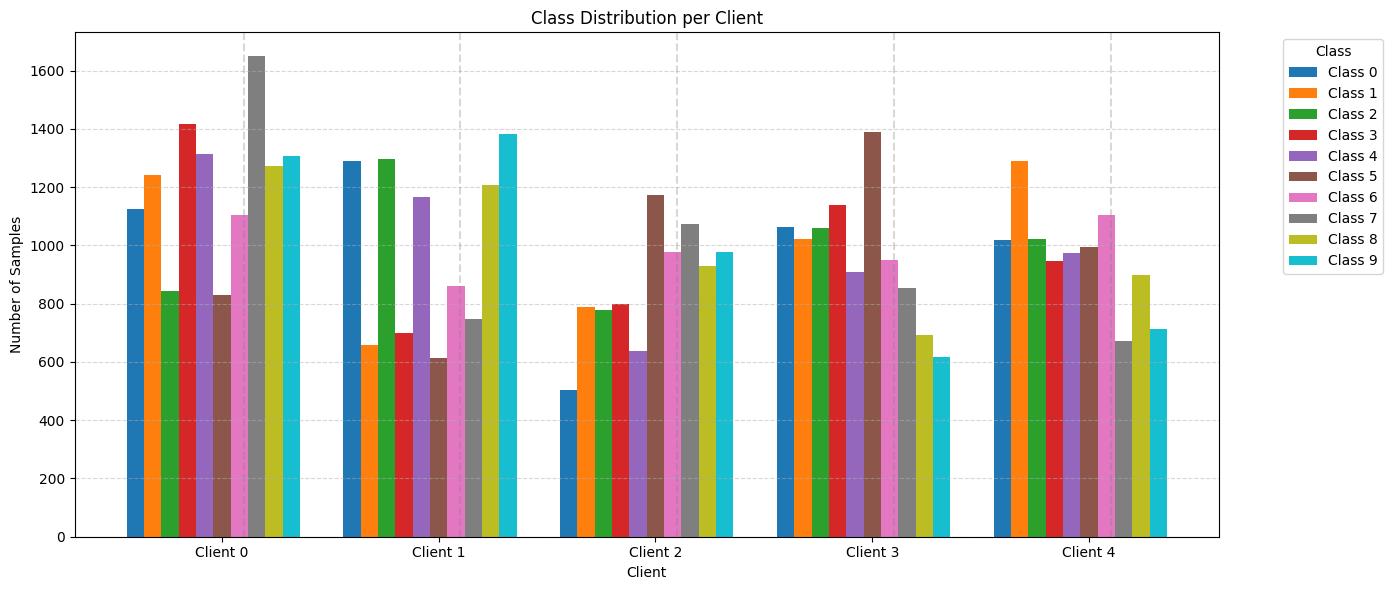

In [ ]:
print_partition_statistics(fds_high_alpha, num_partitions=NUM_CLIENTS, plot=True)

# Testing/Evaluating different Partitioners/Strategies

Now that we have a nice and modular setup and showed how different Partitioners split up data, we evaluate how well they perform.

For this, we will test out always how well FedAvg works and then compare it to FedProx. FedProx has been shown to work really well on highly skewed data, which could be beneficial in our Non-IID cases.

First of all, we define a run_experiment Function, in order to call a simulation with specific setup in one line:

In [ ]:
def run_experiment(fds, model_fn, strategy_fn, experiment_name, backend_config, num_clients, strategy_cls, num_rounds, partitioner, save_dir="results", **strategy_kwargs):
    print(f"\n🚀 Running experiment: {experiment_name}")
    metrics_log = []

    client_fn = create_client_fn(fds, partitioner)
    client = ClientApp(client_fn=client_fn)

    server_fn = server_fn_factory(strategy_fn, model_fn, metrics_log, fds, strategy_cls, num_rounds, **strategy_kwargs)
    server = ServerApp(server_fn=server_fn)

    run_simulation(
        server_app=server,
        client_app=client,
        num_supernodes=num_clients,
        backend_config=backend_config,
    )

    if metrics_log:
        plot_accuracy(metrics_log, experiment_name, save_dir)

    print(f"✅ Finished: {experiment_name}")
    return metrics_log


Now that we defined this function, we can test out all kinds of Model, Aggregation Strategy and Data combinations. For this we loop over all our fds and then use both strategies on it.

DEBUG:flwr:Asyncio event loop already running.



🚀 Running experiment: base_IID_fedavg_experiment


INFO :      Starting Flower ServerApp, config: num_rounds=8, round_timeout=120s
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=3867) 2025-06-05 12:39:49.803074: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=3867) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=3867) E0000 00:00:1749127189.836519    3867 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=3867) E0000 00:00:1749127189.848270    3867 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=3868) /usr/local/lib/python3.11/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is mi

📊 Server round 0 accuracy: 0.1029


(ClientAppActor pid=3867) /usr/local/lib/python3.11/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=3867) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=3867) see the appropriate new directories, set the environment variable
(ClientAppActor pid=3867) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=3867) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=3867)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (1, 0.0, {'accuracy': 0.3735}, 59.15123558999994)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 1 accuracy: 0.3735


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (2, 0.0, {'accuracy': 0.4593}, 121.30504739399998)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 2 accuracy: 0.4593


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (3, 0.0, {'accuracy': 0.5185}, 185.94308447499998)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 3 accuracy: 0.5185


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (4, 0.0, {'accuracy': 0.569}, 247.24495441600004)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 4 accuracy: 0.5690


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (5, 0.0, {'accuracy': 0.6018}, 310.62665868)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 5 accuracy: 0.6018


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (6, 0.0, {'accuracy': 0.6296}, 373.3084767590001)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 6 accuracy: 0.6296


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (7, 0.0, {'accuracy': 0.6597}, 436.5367848000001)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 7 accuracy: 0.6597


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (8, 0.0, {'accuracy': 0.6736}, 504.014833468)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 8 accuracy: 0.6736


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 8 round(s) in 512.11s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.14276910388469696
INFO :      		round 2: 0.12646181765794753
INFO :      		round 3: 0.09717673642635345
INFO :      		round 4: 0.07833009533286095
INFO :      		round 5: 0.06772559931576252
INFO :      		round 6: 0.062437838757038115
INFO :      		round 7: 0.056578741136193274
INFO :      		round 8: 0.054285419130325314
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.0
INFO :      		round 1: 0.0
INFO :      		round 2: 0.0
INFO :      		round 3: 0.0
INFO :      		round 4: 0.0
INFO :      		round 5: 0.0
INFO :      		round 6: 0.0
INFO :      		round 7: 0.0
INFO :      		round 8: 0.0
INFO :      	History (metrics, centralized):
INFO :      	{'accuracy': [(0, 0.1029),
INFO :      	              (1, 0.3735),
INFO :      	              (2, 0.4593),
INFO :      	

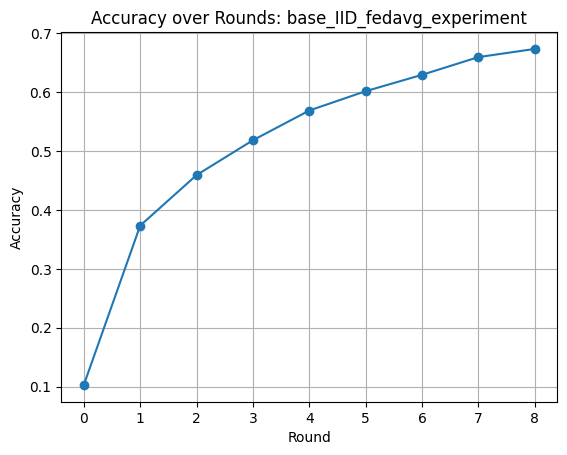

✅ Finished: base_IID_fedavg_experiment

🚀 Running experiment: base_IID_fedprox_experiment


INFO :      Starting Flower ServerApp, config: num_rounds=8, round_timeout=120s
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=6468) 2025-06-05 12:48:49.776296: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=6468) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=6468) E0000 00:00:1749127729.817472    6468 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=6468) E0000 00:00:1749127729.830757    6468 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=6469) /usr/local/lib/python3.11/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is mi

📊 Server round 0 accuracy: 0.1043


(ClientAppActor pid=6468) /usr/local/lib/python3.11/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=6468) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=6468) see the appropriate new directories, set the environment variable
(ClientAppActor pid=6468) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=6468) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=6468)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (1, 0.0, {'accuracy': 0.3715}, 57.52285540799994)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 1 accuracy: 0.3715


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (2, 0.0, {'accuracy': 0.4441}, 120.6243465)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 2 accuracy: 0.4441


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (3, 0.0, {'accuracy': 0.5008}, 183.593575632)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 3 accuracy: 0.5008


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (4, 0.0, {'accuracy': 0.5502}, 246.83921578600007)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 4 accuracy: 0.5502


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (5, 0.0, {'accuracy': 0.5988}, 308.30346198300003)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 5 accuracy: 0.5988


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (6, 0.0, {'accuracy': 0.6294}, 370.26189977600006)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 6 accuracy: 0.6294


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (7, 0.0, {'accuracy': 0.6525}, 434.8482026280001)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 7 accuracy: 0.6525


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (8, 0.0, {'accuracy': 0.6716}, 495.89619979200006)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 8 accuracy: 0.6716


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 8 round(s) in 503.98s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.14239776604175566
INFO :      		round 2: 0.12707170490026473
INFO :      		round 3: 0.098936168384552
INFO :      		round 4: 0.07867203376889229
INFO :      		round 5: 0.06797583911716938
INFO :      		round 6: 0.061498093873262404
INFO :      		round 7: 0.05764804927110672
INFO :      		round 8: 0.05464839417040348
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.0
INFO :      		round 1: 0.0
INFO :      		round 2: 0.0
INFO :      		round 3: 0.0
INFO :      		round 4: 0.0
INFO :      		round 5: 0.0
INFO :      		round 6: 0.0
INFO :      		round 7: 0.0
INFO :      		round 8: 0.0
INFO :      	History (metrics, centralized):
INFO :      	{'accuracy': [(0, 0.1043),
INFO :      	              (1, 0.3715),
INFO :      	              (2, 0.4441),
INFO :      	    

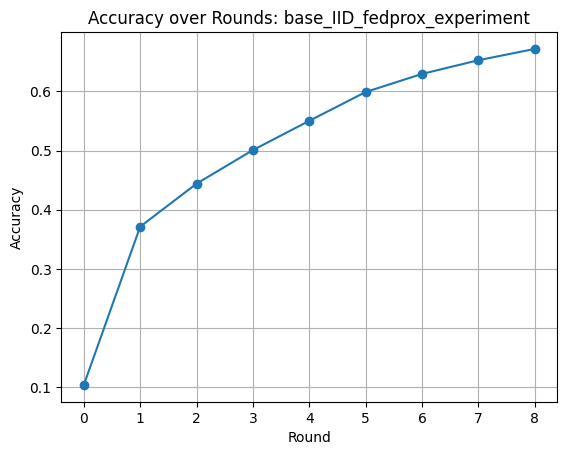

✅ Finished: base_IID_fedprox_experiment

🚀 Running experiment: low_alpha_dirichlet_fedavg_experiment


INFO :      Starting Flower ServerApp, config: num_rounds=8, round_timeout=120s
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=9083) 2025-06-05 12:57:41.298547: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=9083) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=9083) E0000 00:00:1749128261.333908    9083 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=9083) E0000 00:00:1749128261.343490    9083 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=9085) /usr/local/lib/python3.11/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is mi

📊 Server round 0 accuracy: 0.1032


(ClientAppActor pid=9083) /usr/local/lib/python3.11/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=9083) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=9083) see the appropriate new directories, set the environment variable
(ClientAppActor pid=9083) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=9083) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=9083)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (1, 0.0, {'accuracy': 0.3765}, 57.371340532999966)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 1 accuracy: 0.3765


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (2, 0.0, {'accuracy': 0.4056}, 121.58821463200002)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 2 accuracy: 0.4056


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (3, 0.0, {'accuracy': 0.4505}, 182.57897253600004)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 3 accuracy: 0.4505


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (4, 0.0, {'accuracy': 0.5036}, 245.457685675)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 4 accuracy: 0.5036


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (5, 0.0, {'accuracy': 0.5359}, 307.0540518810001)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 5 accuracy: 0.5359


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (6, 0.0, {'accuracy': 0.5489}, 371.56044096999995)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 6 accuracy: 0.5489


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (7, 0.0, {'accuracy': 0.5779}, 432.6090579470001)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 7 accuracy: 0.5779


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (8, 0.0, {'accuracy': 0.5997}, 495.78475192899987)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 8 accuracy: 0.5997


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 8 round(s) in 502.57s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.14321145616717545
INFO :      		round 2: 0.13249703294662668
INFO :      		round 3: 0.1173231291020852
INFO :      		round 4: 0.10934169969554654
INFO :      		round 5: 0.11070386615764223
INFO :      		round 6: 0.11347083232119894
INFO :      		round 7: 0.10192496855989257
INFO :      		round 8: 0.09866854276236056
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.0
INFO :      		round 1: 0.0
INFO :      		round 2: 0.0
INFO :      		round 3: 0.0
INFO :      		round 4: 0.0
INFO :      		round 5: 0.0
INFO :      		round 6: 0.0
INFO :      		round 7: 0.0
INFO :      		round 8: 0.0
INFO :      	History (metrics, centralized):
INFO :      	{'accuracy': [(0, 0.1032),
INFO :      	              (1, 0.3765),
INFO :      	              (2, 0.4056),
INFO :      	    

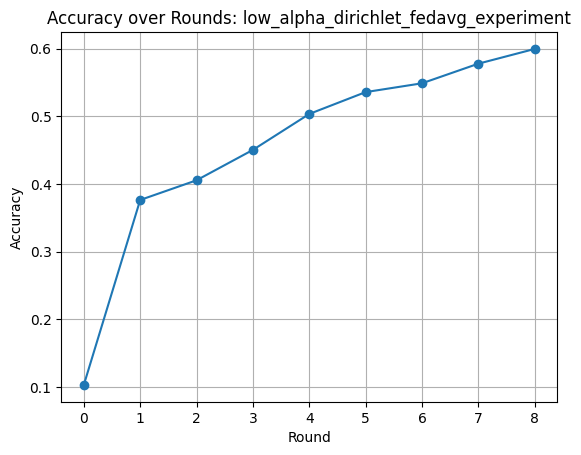

✅ Finished: low_alpha_dirichlet_fedavg_experiment

🚀 Running experiment: low_alpha_dirichlet_fedprox_experiment


INFO :      Starting Flower ServerApp, config: num_rounds=8, round_timeout=120s
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=11694) 2025-06-05 13:06:29.094096: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=11694) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=11694) E0000 00:00:1749128789.130594   11694 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=11694) E0000 00:00:1749128789.140498   11694 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=11694) /usr/local/lib/python3.11/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter 

📊 Server round 0 accuracy: 0.1007


(ClientAppActor pid=11693) /usr/local/lib/python3.11/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=11693) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=11693) see the appropriate new directories, set the environment variable
(ClientAppActor pid=11693) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=11693) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=11693)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (1, 0.0, {'accuracy': 0.3819}, 61.556240574000185)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 1 accuracy: 0.3819


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (2, 0.0, {'accuracy': 0.4128}, 122.29452376600011)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 2 accuracy: 0.4128


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (3, 0.0, {'accuracy': 0.4374}, 184.78126636099978)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 3 accuracy: 0.4374


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (4, 0.0, {'accuracy': 0.4828}, 245.93199676899985)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 4 accuracy: 0.4828


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (5, 0.0, {'accuracy': 0.5335}, 310.012476718)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 5 accuracy: 0.5335


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (6, 0.0, {'accuracy': 0.5537}, 370.8395809499998)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 6 accuracy: 0.5537


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (7, 0.0, {'accuracy': 0.5443}, 433.09989654799983)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 7 accuracy: 0.5443


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (8, 0.0, {'accuracy': 0.5741}, 493.9025922999999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 8 accuracy: 0.5741


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 8 round(s) in 501.98s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.14073899054122094
INFO :      		round 2: 0.13260646513795354
INFO :      		round 3: 0.11916649189968405
INFO :      		round 4: 0.10685303787831735
INFO :      		round 5: 0.10342647250940816
INFO :      		round 6: 0.09729001118421071
INFO :      		round 7: 0.09379017303950804
INFO :      		round 8: 0.08872137683329345
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.0
INFO :      		round 1: 0.0
INFO :      		round 2: 0.0
INFO :      		round 3: 0.0
INFO :      		round 4: 0.0
INFO :      		round 5: 0.0
INFO :      		round 6: 0.0
INFO :      		round 7: 0.0
INFO :      		round 8: 0.0
INFO :      	History (metrics, centralized):
INFO :      	{'accuracy': [(0, 0.1007),
INFO :      	              (1, 0.3819),
INFO :      	              (2, 0.4128),
INFO :      	   

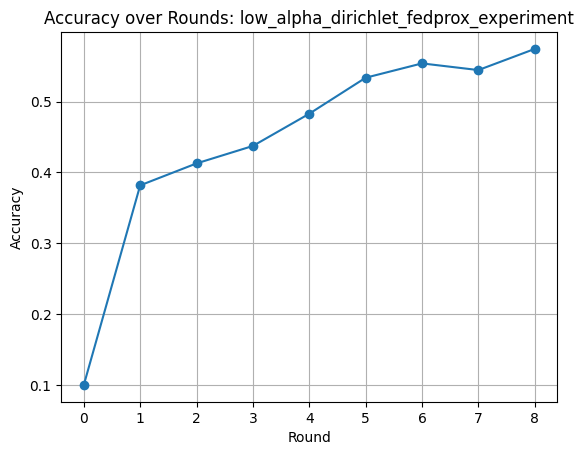

✅ Finished: low_alpha_dirichlet_fedprox_experiment

🚀 Running experiment: high_alpha_dirichlet_fedavg_experiment


INFO :      Starting Flower ServerApp, config: num_rounds=8, round_timeout=120s
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=14302) 2025-06-05 13:15:19.858027: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=14302) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=14302) E0000 00:00:1749129319.892312   14302 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=14302) E0000 00:00:1749129319.902828   14302 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=14303) /usr/local/lib/python3.11/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter 

📊 Server round 0 accuracy: 0.0991


(ClientAppActor pid=14302) /usr/local/lib/python3.11/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=14302) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=14302) see the appropriate new directories, set the environment variable
(ClientAppActor pid=14302) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=14302) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=14302)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (1, 0.0, {'accuracy': 0.3531}, 59.19933732199979)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 1 accuracy: 0.3531


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (2, 0.0, {'accuracy': 0.4499}, 122.45146214299984)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 2 accuracy: 0.4499


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (3, 0.0, {'accuracy': 0.5068}, 183.35409518000006)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 3 accuracy: 0.5068


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (4, 0.0, {'accuracy': 0.5608}, 245.94827044800013)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 4 accuracy: 0.5608


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (5, 0.0, {'accuracy': 0.6}, 308.96350525900016)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 5 accuracy: 0.6000


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (6, 0.0, {'accuracy': 0.6313}, 369.75601770799994)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 6 accuracy: 0.6313


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (7, 0.0, {'accuracy': 0.6571}, 432.5124021030001)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 7 accuracy: 0.6571


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (8, 0.0, {'accuracy': 0.6768}, 496.2231446259998)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 8 accuracy: 0.6768


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 8 round(s) in 503.00s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.14435430024629703
INFO :      		round 2: 0.13010989045443755
INFO :      		round 3: 0.10315283956061945
INFO :      		round 4: 0.08121896812012898
INFO :      		round 5: 0.06985381865455888
INFO :      		round 6: 0.06392240578973016
INFO :      		round 7: 0.056870752398823214
INFO :      		round 8: 0.052502522307495594
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.0
INFO :      		round 1: 0.0
INFO :      		round 2: 0.0
INFO :      		round 3: 0.0
INFO :      		round 4: 0.0
INFO :      		round 5: 0.0
INFO :      		round 6: 0.0
INFO :      		round 7: 0.0
INFO :      		round 8: 0.0
INFO :      	History (metrics, centralized):
INFO :      	{'accuracy': [(0, 0.0991),
INFO :      	              (1, 0.3531),
INFO :      	              (2, 0.4499),
INFO :      	 

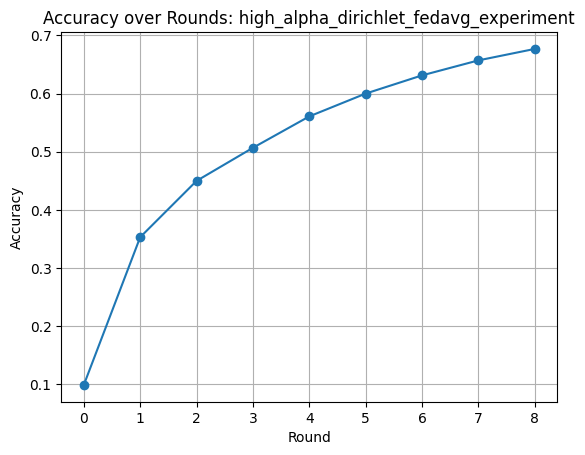

✅ Finished: high_alpha_dirichlet_fedavg_experiment

🚀 Running experiment: high_alpha_dirichlet_fedprox_experiment


INFO :      Starting Flower ServerApp, config: num_rounds=8, round_timeout=120s
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=16870) 2025-06-05 13:24:08.906564: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=16870) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=16870) E0000 00:00:1749129848.941584   16870 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=16870) E0000 00:00:1749129848.951927   16870 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=16870) /usr/local/lib/python3.11/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter 

📊 Server round 0 accuracy: 0.0997


(ClientAppActor pid=16869) /usr/local/lib/python3.11/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=16869) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=16869) see the appropriate new directories, set the environment variable
(ClientAppActor pid=16869) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=16869) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=16869)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (1, 0.0, {'accuracy': 0.353}, 59.06993196199983)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 1 accuracy: 0.3530


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (2, 0.0, {'accuracy': 0.4537}, 120.41335494900022)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 2 accuracy: 0.4537


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (3, 0.0, {'accuracy': 0.5099}, 182.843481805)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 3 accuracy: 0.5099


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (4, 0.0, {'accuracy': 0.5568}, 245.4680107119998)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 4 accuracy: 0.5568


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (5, 0.0, {'accuracy': 0.5979}, 307.04978654800016)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 5 accuracy: 0.5979


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (6, 0.0, {'accuracy': 0.6199}, 369.798608864)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 6 accuracy: 0.6199


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (7, 0.0, {'accuracy': 0.6567}, 431.09166231200015)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 7 accuracy: 0.6567


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (8, 0.0, {'accuracy': 0.6695}, 493.74667383099995)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 8 accuracy: 0.6695


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 8 round(s) in 502.30s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.14335176060293847
INFO :      		round 2: 0.1293164846568671
INFO :      		round 3: 0.09890718328242723
INFO :      		round 4: 0.07732886915619085
INFO :      		round 5: 0.06753739877333047
INFO :      		round 6: 0.06328443910480602
INFO :      		round 7: 0.05800943012558434
INFO :      		round 8: 0.0542071404819806
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.0
INFO :      		round 1: 0.0
INFO :      		round 2: 0.0
INFO :      		round 3: 0.0
INFO :      		round 4: 0.0
INFO :      		round 5: 0.0
INFO :      		round 6: 0.0
INFO :      		round 7: 0.0
INFO :      		round 8: 0.0
INFO :      	History (metrics, centralized):
INFO :      	{'accuracy': [(0, 0.0997),
INFO :      	              (1, 0.353),
INFO :      	              (2, 0.4537),
INFO :      	      

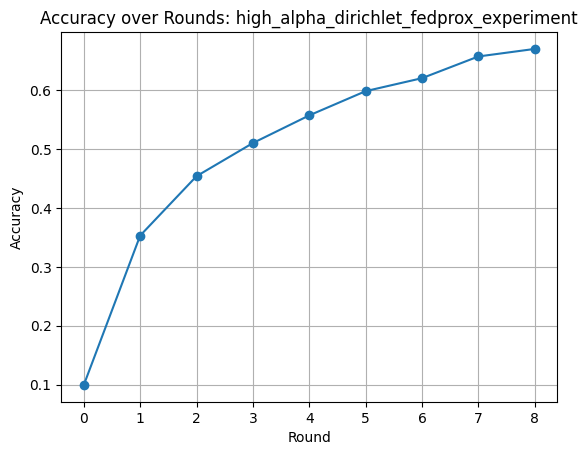

✅ Finished: high_alpha_dirichlet_fedprox_experiment

🚀 Running experiment: pathological_2_fedavg_experiment


INFO :      Starting Flower ServerApp, config: num_rounds=8, round_timeout=120s
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=19477) 2025-06-05 13:32:59.500699: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=19477) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=19477) E0000 00:00:1749130379.572124   19477 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=19477) E0000 00:00:1749130379.592889   19477 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=19478) /usr/local/lib/python3.11/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter 

📊 Server round 0 accuracy: 0.0988


(ClientAppActor pid=19477) /usr/local/lib/python3.11/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=19477) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=19477) see the appropriate new directories, set the environment variable
(ClientAppActor pid=19477) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=19477) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=19477)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (1, 0.0, {'accuracy': 0.1959}, 39.50088642799983)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 1 accuracy: 0.1959


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (2, 0.0, {'accuracy': 0.1925}, 82.05983456000013)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 2 accuracy: 0.1925


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (3, 0.0, {'accuracy': 0.208}, 124.78993675499987)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 3 accuracy: 0.2080


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (4, 0.0, {'accuracy': 0.2148}, 167.74551805500005)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 4 accuracy: 0.2148


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (5, 0.0, {'accuracy': 0.209}, 212.0428586500002)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 5 accuracy: 0.2090


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (6, 0.0, {'accuracy': 0.2278}, 256.96255011899984)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 6 accuracy: 0.2278


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (7, 0.0, {'accuracy': 0.23}, 299.5804871819996)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 7 accuracy: 0.2300


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (8, 0.0, {'accuracy': 0.2359}, 342.7692247279997)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 8 accuracy: 0.2359


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 8 round(s) in 349.89s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.12387468802670669
INFO :      		round 2: 0.12396919950270295
INFO :      		round 3: 0.1377383264055564
INFO :      		round 4: 0.13163340451776087
INFO :      		round 5: 0.12824323980778574
INFO :      		round 6: 0.11806838970192994
INFO :      		round 7: 0.12001950064445559
INFO :      		round 8: 0.10899697938343514
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.0
INFO :      		round 1: 0.0
INFO :      		round 2: 0.0
INFO :      		round 3: 0.0
INFO :      		round 4: 0.0
INFO :      		round 5: 0.0
INFO :      		round 6: 0.0
INFO :      		round 7: 0.0
INFO :      		round 8: 0.0
INFO :      	History (metrics, centralized):
INFO :      	{'accuracy': [(0, 0.0988),
INFO :      	              (1, 0.1959),
INFO :      	              (2, 0.1925),
INFO :      	    

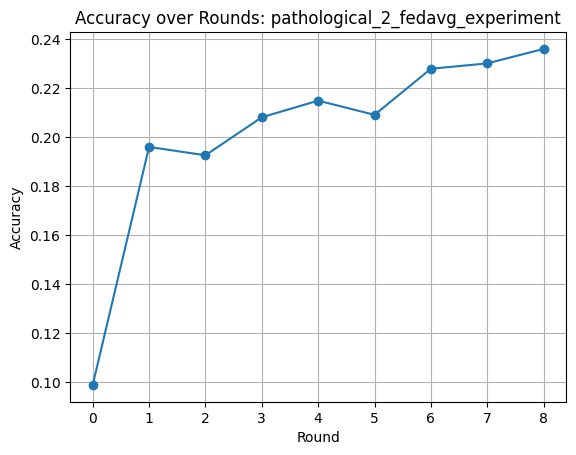

✅ Finished: pathological_2_fedavg_experiment

🚀 Running experiment: pathological_2_fedprox_experiment


INFO :      Starting Flower ServerApp, config: num_rounds=8, round_timeout=120s
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=21444) 2025-06-05 13:39:15.954578: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=21444) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=21444) E0000 00:00:1749130756.036442   21444 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=21444) E0000 00:00:1749130756.066850   21444 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=21444) /usr/local/lib/python3.11/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter 

📊 Server round 0 accuracy: 0.0945


(ClientAppActor pid=21443) /usr/local/lib/python3.11/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=21443) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=21443) see the appropriate new directories, set the environment variable
(ClientAppActor pid=21443) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=21443) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=21443)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (1, 0.0, {'accuracy': 0.1907}, 40.174991554999906)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 1 accuracy: 0.1907


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (2, 0.0, {'accuracy': 0.2193}, 83.48359288099982)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 2 accuracy: 0.2193


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (3, 0.0, {'accuracy': 0.2085}, 127.12592819099973)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 3 accuracy: 0.2085


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (4, 0.0, {'accuracy': 0.2115}, 169.8237923939996)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 4 accuracy: 0.2115


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (5, 0.0, {'accuracy': 0.2397}, 213.29712746099995)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 5 accuracy: 0.2397


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (6, 0.0, {'accuracy': 0.1839}, 256.49434722599926)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 6 accuracy: 0.1839


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (7, 0.0, {'accuracy': 0.2095}, 299.07632133599964)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 7 accuracy: 0.2095


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (8, 0.0, {'accuracy': 0.2135}, 342.37703958399925)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 8 accuracy: 0.2135


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 8 round(s) in 349.57s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.11887834583240225
INFO :      		round 2: 0.11951242322009993
INFO :      		round 3: 0.1252498135394843
INFO :      		round 4: 0.1205080257688014
INFO :      		round 5: 0.11842612209682897
INFO :      		round 6: 0.11751741556671805
INFO :      		round 7: 0.11034405256861259
INFO :      		round 8: 0.10827811867511393
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.0
INFO :      		round 1: 0.0
INFO :      		round 2: 0.0
INFO :      		round 3: 0.0
INFO :      		round 4: 0.0
INFO :      		round 5: 0.0
INFO :      		round 6: 0.0
INFO :      		round 7: 0.0
INFO :      		round 8: 0.0
INFO :      	History (metrics, centralized):
INFO :      	{'accuracy': [(0, 0.0945),
INFO :      	              (1, 0.1907),
INFO :      	              (2, 0.2193),
INFO :      	     

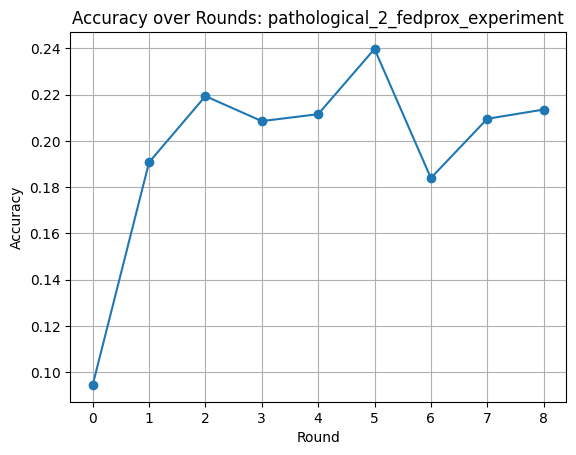

✅ Finished: pathological_2_fedprox_experiment

🚀 Running experiment: pathological_5_fedavg_experiment


INFO :      Starting Flower ServerApp, config: num_rounds=8, round_timeout=120s
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=23425) 2025-06-05 13:45:34.838138: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=23425) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=23425) E0000 00:00:1749131134.873452   23425 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=23425) E0000 00:00:1749131134.890942   23425 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=23425) /usr/local/lib/python3.11/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter 

📊 Server round 0 accuracy: 0.0958


(ClientAppActor pid=23424) /usr/local/lib/python3.11/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=23424) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=23424) see the appropriate new directories, set the environment variable
(ClientAppActor pid=23424) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=23424) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=23424)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (1, 0.0, {'accuracy': 0.185}, 59.24115956600053)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 1 accuracy: 0.1850


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (2, 0.0, {'accuracy': 0.2561}, 125.73780486600026)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 2 accuracy: 0.2561


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (3, 0.0, {'accuracy': 0.2677}, 192.48578380799972)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 3 accuracy: 0.2677


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (4, 0.0, {'accuracy': 0.2978}, 260.0940909050005)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 4 accuracy: 0.2978


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (5, 0.0, {'accuracy': 0.3358}, 326.4988227240001)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 5 accuracy: 0.3358


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (6, 0.0, {'accuracy': 0.3736}, 393.36916989699967)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 6 accuracy: 0.3736


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (7, 0.0, {'accuracy': 0.4099}, 459.76656906399967)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 7 accuracy: 0.4099


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (8, 0.0, {'accuracy': 0.4681}, 527.4456992679998)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 8 accuracy: 0.4681


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 8 round(s) in 537.52s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.15061971200299476
INFO :      		round 2: 0.15363253256820417
INFO :      		round 3: 0.1593436818403148
INFO :      		round 4: 0.14694393432653052
INFO :      		round 5: 0.13768581458964582
INFO :      		round 6: 0.1297417480419097
INFO :      		round 7: 0.12064238278243074
INFO :      		round 8: 0.10948275187989921
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.0
INFO :      		round 1: 0.0
INFO :      		round 2: 0.0
INFO :      		round 3: 0.0
INFO :      		round 4: 0.0
INFO :      		round 5: 0.0
INFO :      		round 6: 0.0
INFO :      		round 7: 0.0
INFO :      		round 8: 0.0
INFO :      	History (metrics, centralized):
INFO :      	{'accuracy': [(0, 0.0958),
INFO :      	              (1, 0.185),
INFO :      	              (2, 0.2561),
INFO :      	      

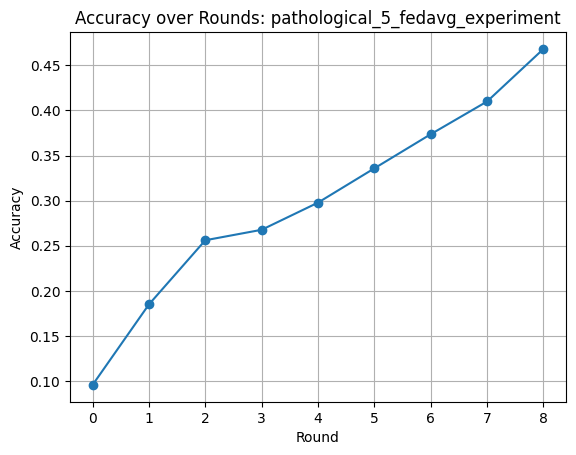

✅ Finished: pathological_5_fedavg_experiment

🚀 Running experiment: pathological_5_fedprox_experiment


INFO :      Starting Flower ServerApp, config: num_rounds=8, round_timeout=120s
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=26183) 2025-06-05 13:55:00.552308: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=26183) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=26183) E0000 00:00:1749131700.585946   26183 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=26183) E0000 00:00:1749131700.596547   26183 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=26183) /usr/local/lib/python3.11/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter 

📊 Server round 0 accuracy: 0.0980


(ClientAppActor pid=26182) /usr/local/lib/python3.11/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=26182) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=26182) see the appropriate new directories, set the environment variable
(ClientAppActor pid=26182) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=26182) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=26182)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (1, 0.0, {'accuracy': 0.2037}, 59.18885682400014)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 1 accuracy: 0.2037


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (2, 0.0, {'accuracy': 0.2284}, 125.47098264400029)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 2 accuracy: 0.2284


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (3, 0.0, {'accuracy': 0.2785}, 193.63891235700066)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 3 accuracy: 0.2785


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (4, 0.0, {'accuracy': 0.3094}, 260.3860559900004)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 4 accuracy: 0.3094


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (5, 0.0, {'accuracy': 0.3548}, 326.33157964400016)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 5 accuracy: 0.3548


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (6, 0.0, {'accuracy': 0.3902}, 392.619333652)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 6 accuracy: 0.3902


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (7, 0.0, {'accuracy': 0.4486}, 459.3593857720007)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 7 accuracy: 0.4486


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (8, 0.0, {'accuracy': 0.4437}, 526.2290435479999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


📊 Server round 8 accuracy: 0.4437


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 8 round(s) in 536.20s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.15443018484836118
INFO :      		round 2: 0.1610658080716955
INFO :      		round 3: 0.15638142721674292
INFO :      		round 4: 0.14771503406175915
INFO :      		round 5: 0.14014806732642693
INFO :      		round 6: 0.13351266790821706
INFO :      		round 7: 0.11809873318791311
INFO :      		round 8: 0.11344788821040463
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.0
INFO :      		round 1: 0.0
INFO :      		round 2: 0.0
INFO :      		round 3: 0.0
INFO :      		round 4: 0.0
INFO :      		round 5: 0.0
INFO :      		round 6: 0.0
INFO :      		round 7: 0.0
INFO :      		round 8: 0.0
INFO :      	History (metrics, centralized):
INFO :      	{'accuracy': [(0, 0.098),
INFO :      	              (1, 0.2037),
INFO :      	              (2, 0.2284),
INFO :      	     

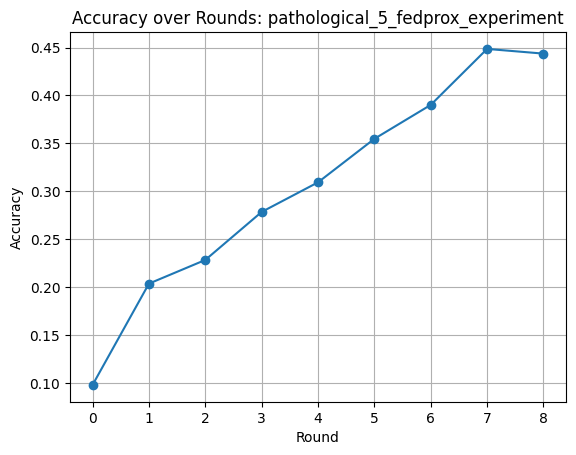

✅ Finished: pathological_5_fedprox_experiment


In [ ]:
from flwr.server.strategy import FedAvg, FedProx

# List of federated datasets
fds_list = [
    ("base_IID", iid_fds, iid_partitioner),
    ("low_alpha_dirichlet", fds_low_alpha, partitioner_low_alpha),
    ("high_alpha_dirichlet", fds_high_alpha, partitioner_high_alpha),
    ("pathological_2", fds_pathological_2, partitioner_pathological_2),
    ("pathological_5", fds_pathological_5, partitioner_pathological_5),
]
strategies = [FedAvg, FedProx]

NUM_ROUNDS=8

# Loop through each dataset and each strategy
for fds_name, fds, partitioner in fds_list:
    for strategy_cls in strategies:
        experiment_name = f"{fds_name}_{strategy_cls.__name__.lower()}_experiment"

        if strategy_cls == FedProx:
          run_experiment(
              fds=fds,
              partitioner=partitioner,
              model_fn=model_fn,
              strategy_fn=strategy_fn,
              experiment_name=experiment_name,
              backend_config=backend_config,
              num_clients=NUM_CLIENTS,
              strategy_cls=strategy_cls,
              save_dir="results",
              num_rounds=8,
              proximal_mu= 0.01)

        else:
          run_experiment(
            fds=fds,
            partitioner=partitioner,
            model_fn=model_fn,
            strategy_fn=strategy_fn,
            experiment_name=experiment_name,
            backend_config=backend_config,
            num_clients=NUM_CLIENTS,
            strategy_cls=strategy_cls,
            save_dir="results",
            num_rounds=8
          )

# Interpretation of Results
After doing a lot of test-runs which are quite heavy computation, we decided to group the results here to get a good overview.

We used 5 Clients for our experiment, with 8 rounds in total. On the client fit function we just compute the loss once each time (epochs=1). In reality this parameters should be tested out and especially epochs should be set higher.

Let's look at how well our different Strategies FedAvg and FedProx performed on the different Data-Distributions.

NOTE: In this notebook the files get saved to a directory called results. However the computation took us multiple hours on Google-Colab using the GPU backend, therefore you can also get the required plots on github and upload them into Colab or your local directory to be able to interpret the results.

Github: (https://github.com/aherzinger/federated_transfer_learning/blob/main/Heterogeneous_FTL.ipynb)

## Results on IID-Data
For reference, we first ran our experiments on our IID FederatedDataset. With both strategies we reached about 68% accuracy after 8 epochs, using more rounds we might get up to 70%.

It can be seen on the graphs that the strategy does not really matter in this case, which was also expected.

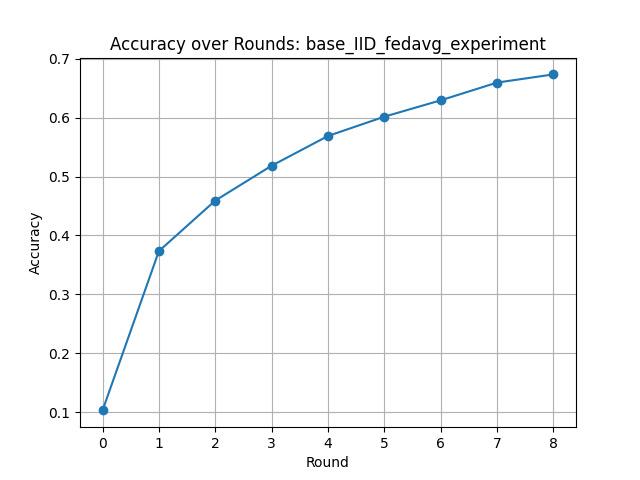

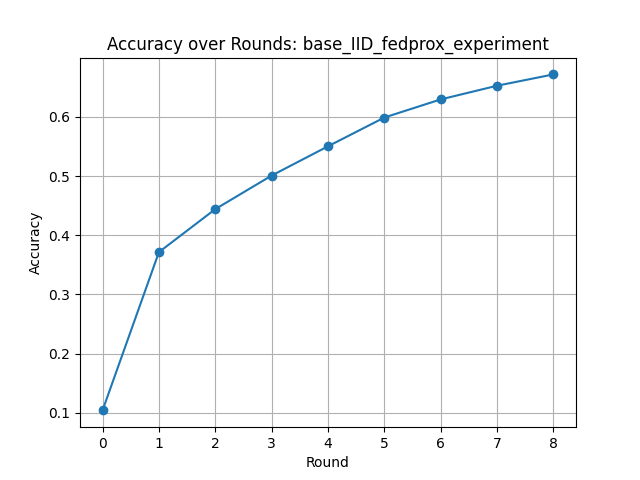

In [ ]:
display(Image(filename="/content/results/base_IID_fedavg_experiment_accuracy.png"))
display(Image(filename="/content/results/base_IID_fedprox_experiment_accuracy.png"))


As we can see it doesn't seem to matter which strategy we use. Now we can use this as our baseline - how much worse will Non-IID data be?

## Results on PathologicalPartitioner

For the PathologicalPartitioner we ran our experiments twice: once with a maximum of 2 labels per client (extremly Non-IID) and once ith a maximum of 5 labels per client (a bit better but still quite extreme).

Both of our approaches really struggled with performance in our experiments. First of all we will look at the 2 labels per partition case:

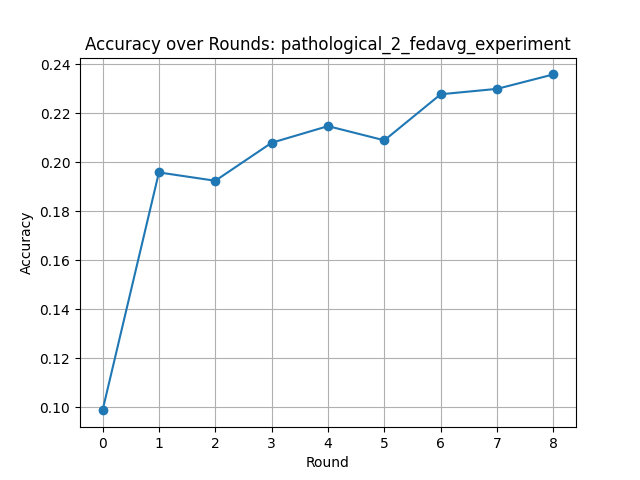

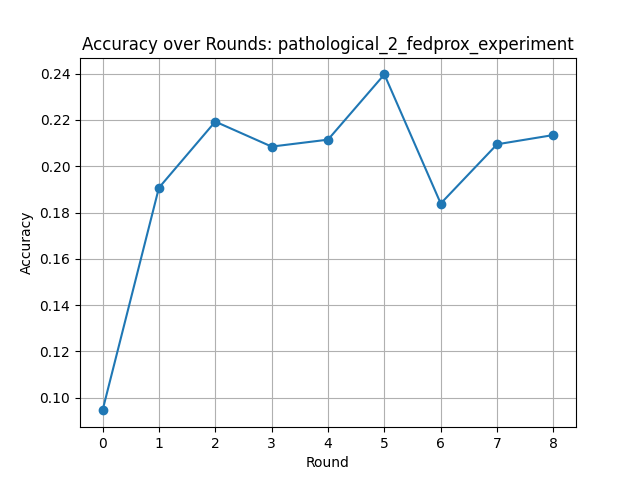

In [ ]:
display(Image(filename="/content/results/pathological_2_fedavg_experiment_accuracy.png"))
display(Image(filename="/content/results/pathological_2_fedprox_experiment_accuracy.png"))

We can see that both approaches don't really learn well. However what we can conclude is that it might be safer to use the FedAvg strategy in this case, with a lot more rounds we might get better performance.

But this also works the other way, if one could find a really advanced aggregation strategy, it might perform a lot better.

In our experiments however, we can not be satisfied with the result and this shows that it is a really hard task to work with this extremely skewed data.

Let's see how well our setup works with the Pathological setup of 5 classes per client:

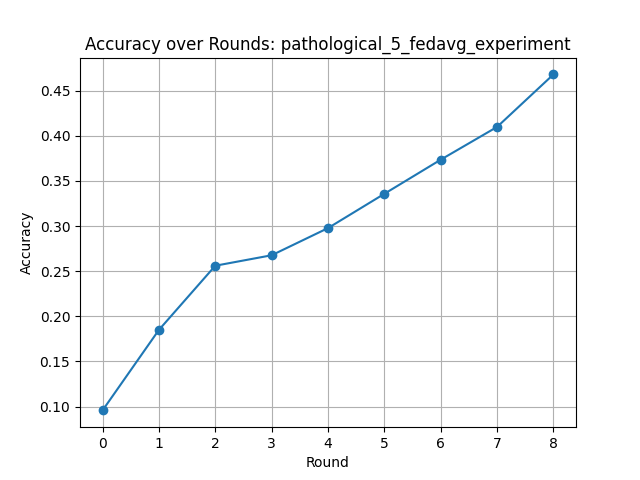

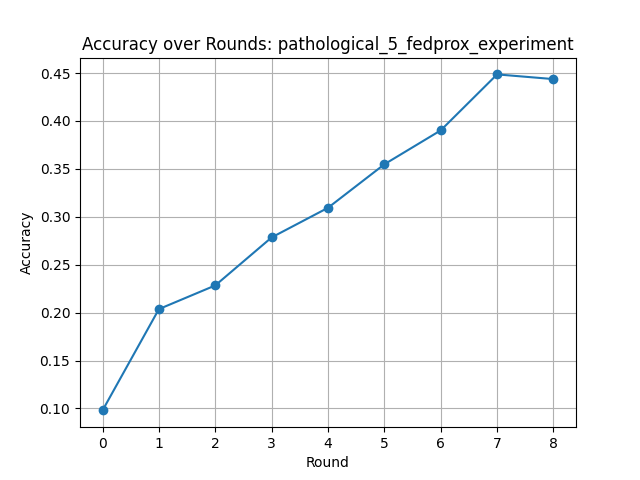

In [ ]:
display(Image(filename="/content/results/pathological_5_fedavg_experiment_accuracy.png"))
display(Image(filename="/content/results/pathological_5_fedprox_experiment_accuracy.png"))

With 5 classes per client our model seems to learn quite well, however it is a bit slower. With more runs we might get a bit more performance out of it. Also in this case FedAvg is the prefered strategy in our usecase, since it learns steadier and gives us a better result.


## Results on DirichletPartitioner
Also for the DirichletPartitioner we ran our experiments twice, once with low alpha and once with high alpha. As illurstrated in the Distribution Section, low alpha makes the data really non-IID, while high alpha just slightly does so.

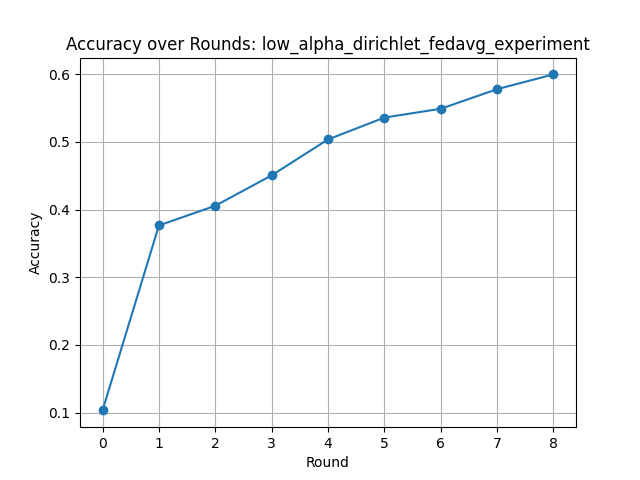

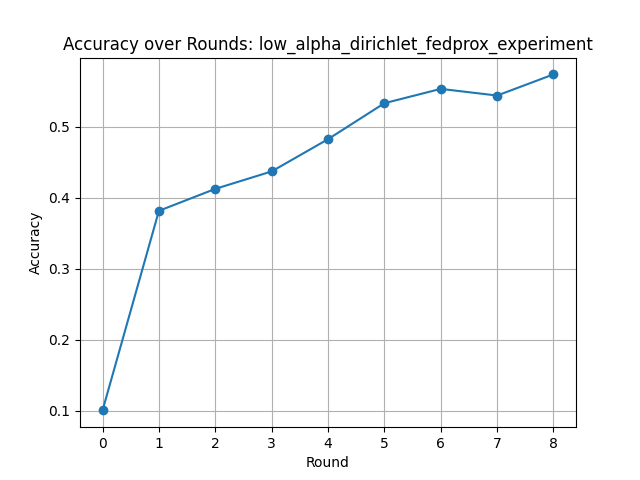

In [ ]:
display(Image(filename="/content/results/low_alpha_dirichlet_fedavg_experiment_accuracy.png"))
display(Image(filename="/content/results/low_alpha_dirichlet_fedprox_experiment_accuracy.png"))

We can observe that also in these case the FedAvg strategy is the better choice, achieving a more stable and overall better result.

It is remarkable that our model performs so well, considering that this data is highly skewed. However here every client has all labels, just in different quantities and that seems to make the difference.

Let's also look at the DirichletPartitioner with high alpha (more regular but still non-IID):

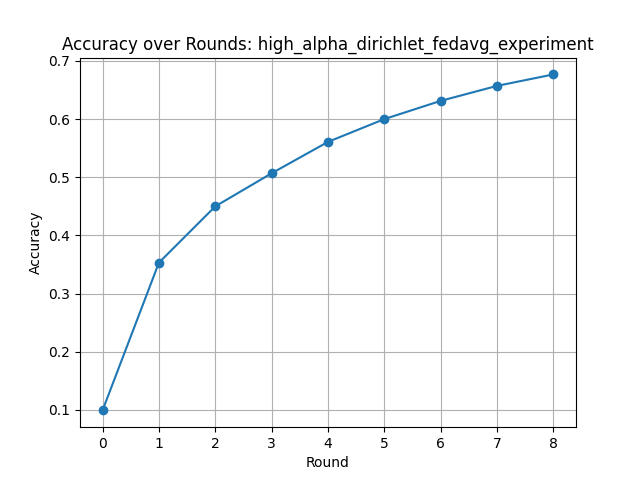

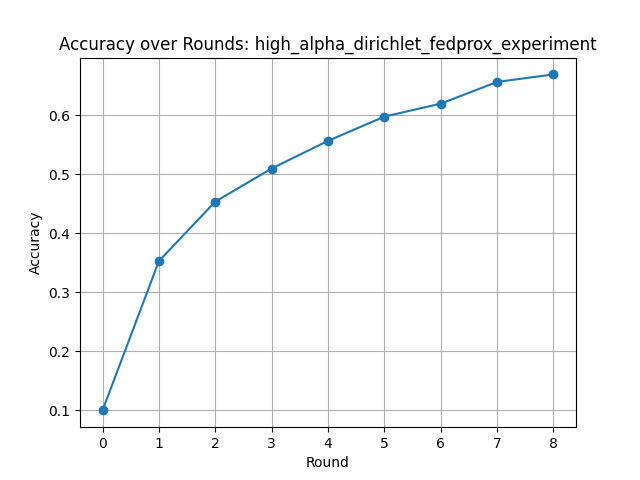

In [ ]:
display(Image(filename="/content/results/high_alpha_dirichlet_fedavg_experiment_accuracy.png"))
display(Image(filename="/content/results/high_alpha_dirichlet_fedprox_experiment_accuracy.png"))

On this run we can see that our model performed really similar to our IID benchmark, an expected result since the data is quite evenly distributed.

Also in this case the strategy does not make a huge difference.

The Dirichlet Distribution also has the advantage that it replicates real world scenarios really well - we might have really different data amount, however in a usual setup most clients will have at least a little bit of data of each class.

Especially the run with low_alpha has shown that FTL works really well on these setups.

## Conclusion
The results have shown to be really dependant on the distribution which we gave to our clients. The distribution has shown to be the main factor, in most cases FedAvg worked similarly well as FedProx. Our intution is that it is really hard to find the right hyperparameters for a Strategy different than FedAvg to be significantly better.

Also regarding the Setup in general, there are a whole set of hyperparameters that would need to be optimized, how ever this needs a significant amount of computational power, which we don't have at this moment.

In reality we really often encounter the Dirichlet Distribution, it makes a lot more sense to use this one instead of the Pathological Partitioners. While they might be good for experimentation, they likely don't replicate real world scenarios. Our models performed a lot better on Dirichlet, which is remarkable. It seems that while having really skewed data, the model learns really well if the classes per client are more evenly distributed. Since its a kind of reversed Normal Distribution, this is usually the case.

All in all the results clearly show how a basic FTL setup works and what one has to be careful of - especially regarding the Distribution of Non-IID Data.